# 🦠 Malaria Detection Using Deep Learning 🧬

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected mosquitoes. It remains a major global health issue, especially in tropical and subtropical regions. Early detection and accurate diagnosis are critical for effective treatment and saving lives.

In this project, we tackle the problem of malaria diagnosis using deep learning techniques. By leveraging a Convolutional Neural Network (CNN), we aim to classify cell images as either **parasitized** or **uninfected**.

### 🔍 What’s in this notebook?

- 📥 **Dataset**: We'll use the **Malaria Cell Images Dataset** from [`TensorFlow Datasets (TFDS)`](https://www.tensorflow.org/datasets/catalog/malaria). This dataset contains over 27,000 cell images labeled as either parasitized or uninfected.
- 🧹 **Data Preprocessing**: Resizing, normalization, and batching of image data.
- 🧠 **Model Building**: A CNN-based architecture for binary image classification.
- 🧪 **Model Training & Evaluation**: Training the model and evaluating it on validation and test sets.
- 📊 **Visualization**: Accuracy, loss curves, and confusion matrix for insights.

### 🎯 Goal

To build a deep learning model that can **automatically detect malaria-infected cells from microscopic images**, assisting healthcare professionals in faster and more accurate diagnosis.

---

## Import Statements

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import datetime
import io
import os
import random

from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds

import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomContrast, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp

## Get and inspect the dataset

In [2]:
datasets, dataset_info = tfds.load(
    "malaria",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files = True
)

train_dataset, val_dataset, test_dataset = datasets

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.IV8NSA_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [69]:
train_dataset, val_dataset, test_dataset = datasets

In [50]:
datasets

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [51]:
dataset_info

# 0 for infected
# 1 for uninfected

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [52]:
for i in train_dataset.take(1):
  print(i) # The shape of the images is 103,103,3

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [53]:
len(train_dataset),len(test_dataset),len(val_dataset) # There are around 27k images

(22046, 2756, 2756)

## Data visualization

In [54]:
def get_label_str(label):
  if label == 0:
    return "Parasitized"
  else:
    return "Uninfected"

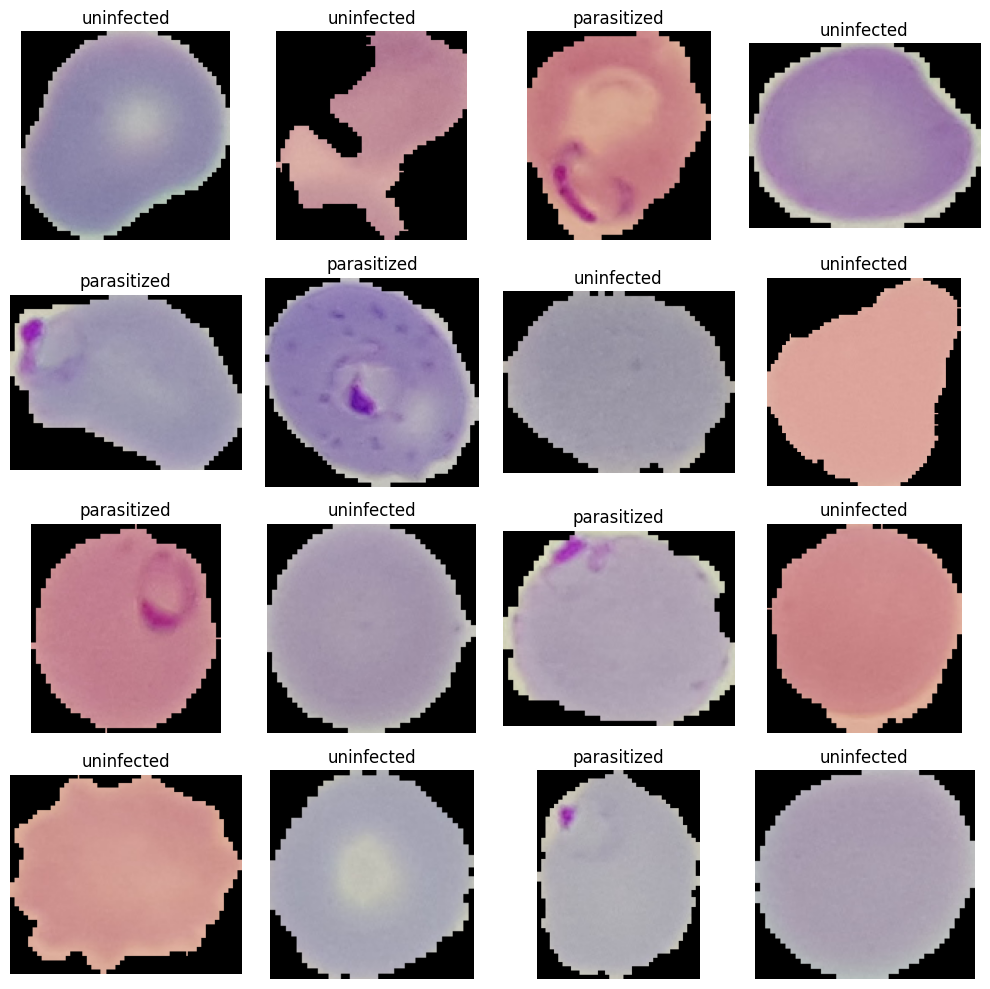

In [55]:
all_samples = list(train_dataset.take(1000))
random_samples = random.sample(all_samples, 16)

plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(random_samples):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [56]:
# Resize all the images into same size

# check the size of random images

for image, label in train_dataset.shuffle(10000).take(1):
  print(image.shape)

(139, 121, 3)


In [57]:
for image, label in train_dataset.shuffle(10000).take(1):
  print(image.shape)

(205, 127, 3)


In [58]:
# Resize all the image to same size

IMG_SIZE = 224

def resize_rescale_image(image,label):
  return tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.,label

In [59]:
BATCH_SIZE = 32
train_dataset = train_dataset.map(resize_rescale_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [60]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [61]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.Conv2D(filters = 8,kernel_size=3,strides = (1,1),padding="valid",activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2,strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 16,kernel_size=3,strides = (1,1),padding="valid",activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2,strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 32,kernel_size=3,strides = (1,1),padding="valid",activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2,strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 64,kernel_size=3,strides = (1,1),padding="valid",activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2,strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation = 'relu'),
    BatchNormalization(),
    tf.keras.layers.Dense(10,activation = 'relu'),
    BatchNormalization(),
    tf.keras.layers.Dense(1,activation = 'sigmoid'),

])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 222, 222, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │       921,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            1

 Total params: 948,169 (3.62 MB)

 Trainable params: 947,709 (3.62 MB)

 Non-trainable params: 460 (1.80 KB)

In [62]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
)

In [63]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

In [64]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 15, verbose = 1,callbacks=[callback])

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7564 - loss: 0.5054 - val_accuracy: 0.6923 - val_loss: 1.0923
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.9356 - loss: 0.1863 - val_accuracy: 0.9038 - val_loss: 0.4142
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.9469 - loss: 0.1661 - val_accuracy: 0.9093 - val_loss: 0.2579
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9501 - loss: 0.1525 - val_accuracy: 0.8959 - val_loss: 0.3283
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.9556 - loss: 0.1396 - val_accuracy: 0.9321 - val_loss: 0.1862
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9537 - loss: 0.1421 - val_accuracy: 0.9242 - val_loss: 0.2397
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9548 - loss: 0.1322 - val_accuracy: 0.9325 - val_loss: 0.1895
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9588 - loss: 0.1244 - 

In [70]:
test_dataset = test_dataset.map(resize_rescale_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [71]:
# Check the shape of one batch in the dataset
for image, label in test_dataset.take(1):
    print(image.shape)  # This should match the input shape of your model
    print(label.shape)  # Labels should have the correct shape


(32, 224, 224, 3)
(32,)


In [72]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9557 - loss: 0.1500


[0.15627188980579376, 0.9531930088996887]

In [73]:
model.save('model.h5')